In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import io

img_orig = io.imread('https://yoyoyo-yo.github.io/Gasyori100knock/dataset/images/imori_256x256.png')
img_128 = io.imread('https://yoyoyo-yo.github.io/Gasyori100knock/dataset/images/imori_128x128.png')
img_gray_128 = cv2.cvtColor(img_128, cv2.COLOR_RGB2GRAY)
img_noise = io.imread('https://yoyoyo-yo.github.io/Gasyori100knock/dataset/images/imori_256x256_noise.png')
img_gray = cv2.cvtColor(img_orig, cv2.COLOR_RGB2GRAY)
img_dark = io.imread('https://yoyoyo-yo.github.io/Gasyori100knock/dataset/images/imori_256x256_dark.png')
img_dark_gray = cv2.cvtColor(img_dark, cv2.COLOR_RGB2GRAY)
img_light = io.imread('https://yoyoyo-yo.github.io/Gasyori100knock/dataset/images/imori_256x256_light.png')
img_light_gray = cv2.cvtColor(img_light, cv2.COLOR_RGB2GRAY)

### Q.31. アフィン変換(スキュー)

Affine (skew)

(1)アフィン変換を用いて、X-sharing(dx = 30)画像を作成せよ。

(2)アフィン変換を用いて、Y-sharing(dy = 30)画像を作成せよ。

(3)アフィン変換を用いて、幾何変換した(dx = 30, dy = 30)画像を作成せよ。

このような画像はスキュー画像と呼ばれ、画像を斜め方向に伸ばした画像である。

出力(1)の場合、x方向にdxだけ引き伸ばした画像はX-sharingと呼ばれる。

出力(2)の場合、y方向にdyだけ引き伸ばした画像はY-sharingと呼ばれる。

それぞれ次式のアフィン変換で実現できる。 ただし、元画像のサイズがh x wとする。

<img src="https://github.com/TakuroTerui/Gasyori100knock/raw/master/questions/question_31_40/images/affine_xysharing.png" width="200"/>

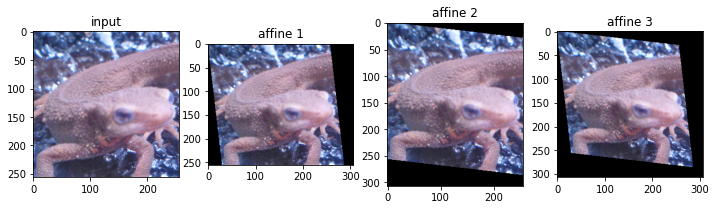

In [2]:
# answer
def affine(img, affine_mat, out_shape):
    h, w, channel = img.shape

    [a, b, tx], [c, d, ty] = affine_mat
    out_h, out_w = map(int, out_shape)
    
    out = np.zeros([out_h, out_w, channel])

    # pad for black
    img_pad = np.pad(img, [(1, 1), (1, 1), (0, 0)])
    
    xs, ys = np.meshgrid(range(out_w), range(out_h)) # output image index

    _xs = np.maximum(np.minimum((1 / (a * d - b * c) * (d * xs - b * ys) - tx).astype(int) + 1, w + 1), 0) # original image index x
    _ys = np.maximum(np.minimum((1 / (a * d - b * c) * (- c * xs + a * ys) - ty).astype(int) + 1, h + 1), 0) # original image index y

    out[ys, xs] = img_pad[_ys, _xs]
    return np.clip(out, 0, 255).astype(np.uint8)

h, w, c = img_orig.shape
img_affine_1 = affine(img_orig, [[1, 30 / h, 0], [0, 1, 0]], (h, w*1.2))
img_affine_2 = affine(img_orig, [[1, 0, 0], [30 / w, 1, 0]], (h * 1.2, w))
img_affine_3 = affine(img_orig, [[1, 30 / h, 0], [30 / w, 1, 0]], (h * 1.2, w*1.2))

plt.figure(figsize=(12, 3))
plt.subplot(1, 4, 1); plt.title('input'); plt.imshow(img_orig)
plt.subplot(1, 4, 2); plt.title('affine 1'); plt.imshow(img_affine_1)
plt.subplot(1, 4, 3); plt.title('affine 2'); plt.imshow(img_affine_2)
plt.subplot(1, 4, 4); plt.title('affine 3'); plt.imshow(img_affine_3)
plt.show()

### Q.32. フーリエ変換

二次元離散フーリエ変換(DFT)を実装し、グレースケールの周波数のパワースペクトルを表示せよ。 また、逆二次元離散フーリエ変換(IDFT)で画像を復元せよ。

二次元離散フーリエ変換(DFT: Discrete Fourier Transformation)とはフーリエ変換の画像に対する処理方法である。

通常のフーリエ変換はアナログ信号や音声などの連続値かつ一次元を対象に周波数成分を求める計算処理である。

一方、ディジタル画像は[0,255]の離散値をとり、かつ画像はHxWの二次元表示であるので、二次元離散フーリエ変換が行われる。

二次元離散フーリエ変換(DFT)は次式で計算される。

K = [0, W-1], l = [0, H-1], 入力画像を I として

<img src="https://github.com/TakuroTerui/Gasyori100knock/raw/master/questions/question_31_40/images/dft.png" width="300"/>

ここではグレースケール画像から二次元離散フーリエ変換を行え。

パワースペクトル... Gは複素数で表されるので、Gの絶対値を求めることである。 今回のみ画像表示の時はパワースペクトルは[0,255]にスケーリングせよ。

逆二次元離散フーリエ変換(IDFT: Inverse DFT)とは周波数成分Gから元の画像を復元する手法であり、次式で定義される。

x = [0, W-1], y = [0, H-1] として

<img src="https://github.com/TakuroTerui/Gasyori100knock/raw/master/questions/question_31_40/images/idft.png" width="300"/>

上が定義式ですがexp(j)は複素数の値をとってしまうので、実際にコードにするときはぜ下式のように絶対値を使います。

<img src="https://github.com/TakuroTerui/Gasyori100knock/raw/master/questions/question_31_40/images/idft_abs.png" width="300"/>

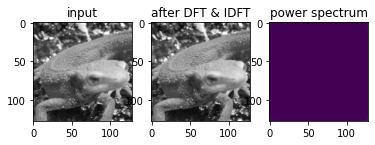

In [3]:
# DFT
def dft(img):
    H, W = img.shape
    G = np.zeros((H, W), dtype=complex)
    x, y = np.meshgrid(np.arange(0, W), np.arange(0, H))

    for l in range(H):
        for k in range(W):
            G[l, k] = np.sum(img * np.exp(-2j * np.pi * (x * k / W + y * l / H)))

    return G

# IDFT
def idft(G):
    H, W = G.shape
    out = np.zeros((H, W), dtype=np.float32)
    x, y = np.meshgrid(np.arange(0, W), np.arange(0, H))
    
    for l in range(H):
        for k in range(W):
            out[l, k] = np.abs(np.sum(G * np.exp(2j * np.pi * (x * k / W + y * l / H)))) / (H * W)

    # clipping
    out = np.clip(out, 0, 255)
    out = out.astype(np.uint8)
    return out

# DFT
G = dft(img_gray_128)

# power spectrum
ps = (np.abs(G) / np.abs(G).max() * 255).astype(np.uint8)

# IDFT
out = idft(G)

plt.subplot(1, 3, 1)
plt.title("input")
plt.imshow(img_gray_128, cmap="gray")
plt.subplot(1, 3, 2)
plt.title("after DFT & IDFT")
plt.imshow(out, cmap="gray")
plt.subplot(1, 3, 3)
plt.title("power spectrum")
plt.imshow(ps)
plt.show()

### Q.33. フーリエ変換 ローパスフィルタ

ローパスフィルタを通してIDFTで画像を復元せよ。

DFTによって得られた周波数成分は左上、右上、左下、右下に近いほど低周波数の成分を含んでいることになり、中心に近いほど高周波成分を示す。

<img src="https://github.com/TakuroTerui/Gasyori100knock/raw/master/questions/question_31_40/images/lpf.png"/>

画像における高周波成分とは色が変わっている部分（ノイズや輪郭など）を示し、低周波成分とは色があまり変わっていない部分（夕日のグラデーションなど）を表す。 ここでは、高周波成分をカットし、低周波成分のみを通すローパスフィルタを実装せよ。

ここでは低周波数の中心から高周波までの距離をrとすると0.5rまでの成分を通すとする。

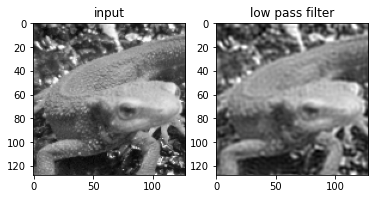

In [4]:
def lpf(G, ratio=0.5):
    H, W = G.shape
    h_half = H // 2
    w_half = W // 2
    
    # transfer positions
    _G = np.zeros_like(G)
    _G[:h_half, :w_half] = G[h_half:, w_half:]
    _G[:h_half, w_half:] = G[h_half:, :w_half]
    _G[h_half:, :w_half] = G[:h_half, w_half:]
    _G[h_half:, w_half:] = G[:h_half, :w_half]

    # filtering
    x, y = np.meshgrid(np.arange(0, W) - w_half, np.arange(0, H) - h_half)

    r = np.sqrt(x ** 2 + y ** 2)
    mask = np.ones((H, W), dtype=np.float32)
    mask[r > (h_half * ratio)] = 0
    _G *= mask

    # reverse original positions
    out = np.zeros_like(_G)
    out[:h_half, :w_half] = _G[h_half:, w_half:]
    out[:h_half, w_half:] = _G[h_half:, :w_half]
    out[h_half:, :w_half] = _G[:h_half, w_half:]
    out[h_half:, w_half:] = _G[:h_half, :w_half]

    return out


G_lpf = lpf(G)
out_lpf = idft(G_lpf)

plt.subplot(1, 2, 1)
plt.title("input")
plt.imshow(img_gray_128, cmap="gray")
plt.subplot(1, 2, 2)
plt.title("low pass filter")
plt.imshow(out_lpf, cmap="gray")
plt.show()

### Q.34. フーリエ変換 ハイパスフィルタ

ハイパスフィルタを通してIDFTで画像を復元せよ。

ここでは、低周波成分をカットし、高周波成分のみを通すハイパスフィルタを実装せよ。

ここでは低周波数の中心から高周波までの距離をrとすると0.1rからの成分を通すとする。

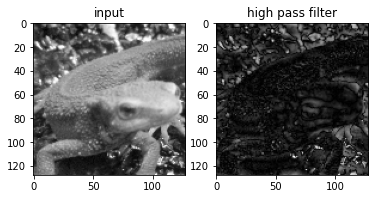

In [5]:
def hpf(G, ratio=0.1):
    H, W = G.shape
    h_half = H // 2
    w_half = W // 2
    
    # transfer positions
    _G = np.zeros_like(G)
    _G[:h_half, :w_half] = G[h_half:, w_half:]
    _G[:h_half, w_half:] = G[h_half:, :w_half]
    _G[h_half:, :w_half] = G[:h_half, w_half:]
    _G[h_half:, w_half:] = G[:h_half, :w_half]

    # filtering
    x, y = np.meshgrid(np.arange(0, W) - w_half, np.arange(0, H) - h_half)
    r = np.sqrt(x ** 2 + y ** 2)
    mask = np.ones((H, W), dtype=np.float32)
    mask[r < (h_half * ratio)] = 0
    _G *= mask

    # reverse original positions
    out = np.zeros_like(_G)
    out[:h_half, :w_half] = _G[h_half:, w_half:]
    out[:h_half, w_half:] = _G[h_half:, :w_half]
    out[h_half:, :w_half] = _G[:h_half, w_half:]
    out[h_half:, w_half:] = _G[:h_half, :w_half]

    return out


G_hpf = hpf(G)
out_hpf = idft(G_hpf)

plt.subplot(1, 2, 1)
plt.title("input")
plt.imshow(img_gray_128, cmap="gray")
plt.subplot(1, 2, 2)
plt.title("high pass filter")
plt.imshow(out_hpf, cmap="gray")
plt.show()

### Q.35. フーリエ変換 バンドパスフィルタ

ハイパスフィルタを通してIDFTで画像を復元せよ。

ここでは、低周波成分と高周波成分の中間の周波数成分のみを通すハイパスフィルタを実装せよ。

ここでは低周波数の中心から高周波までの距離をrとすると0.1rから0.5rまでの成分を通すとする。

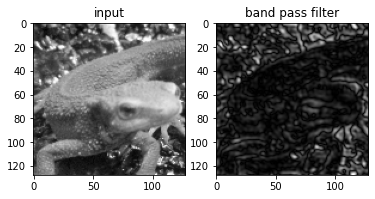

In [6]:
def bpf(G, low=0.1, high=0.5):
    H, W = G.shape
    h_half = H // 2
    w_half = W // 2
    
    # transfer positions
    _G = np.zeros_like(G)
    _G[:h_half, :w_half] = G[h_half:, w_half:]
    _G[:h_half, w_half:] = G[h_half:, :w_half]
    _G[h_half:, :w_half] = G[:h_half, w_half:]
    _G[h_half:, w_half:] = G[:h_half, :w_half]

    # filtering
    x, y = np.meshgrid(np.arange(0, W) - w_half, np.arange(0, H) - h_half)
    r = np.sqrt(x ** 2 + y ** 2)
    mask = np.ones((H, W), dtype=np.float32)
    mask[(r < (h_half * low)) | (r > (h_half * high))] = 0
    _G *= mask

    # reverse original positions
    out = np.zeros_like(_G)
    out[:h_half, :w_half] = _G[h_half:, w_half:]
    out[:h_half, w_half:] = _G[h_half:, :w_half]
    out[h_half:, :w_half] = _G[:h_half, w_half:]
    out[h_half:, w_half:] = _G[:h_half, :w_half]

    return out


G_bpf = bpf(G)
out_bpf = idft(G_bpf)

plt.subplot(1, 2, 1)
plt.title("input")
plt.imshow(img_gray_128, cmap="gray")
plt.subplot(1, 2, 2)
plt.title("band pass filter")
plt.imshow(out_bpf, cmap="gray")
plt.show()

### Q.36. JPEG圧縮 (Step.1)離散コサイン変換

グレースケールを離散コサイン変換を行い、逆離散コサイン変換を行え。

離散コサイン変換(DCT: Discrete Cosine Transformation)とは、次式で定義される周波数変換の一つである。

<img src="https://github.com/TakuroTerui/Gasyori100knock/raw/master/questions/question_31_40/images/dct.png"/>

逆離散コサイン変換(IDCT: Inverse Discrete Cosine Transformation)とは離散コサイン変換の逆（復号）であり、次式で定義される。 ここでいう K は復元時にどれだけ解像度を良くするかを決定するパラメータである。 K = Tの時は、DCT係数を全部使うのでIDCT後の解像度は最大になるが、Kが１や２などの時は復元に使う情報量（DCT係数）が減るので解像度が下がる。これを適度に設定することで、画像の容量を減らすことができる。

<img src="https://github.com/TakuroTerui/Gasyori100knock/raw/master/questions/question_31_40/images/idct.png"/>

ここでは画像を8x8ずつの領域に分割して、各領域で以上のDCT, IDCTを繰り返すことで、jpeg符号に応用される。 今回も同様に8x8の領域に分割して、DCT, IDCTを行え。

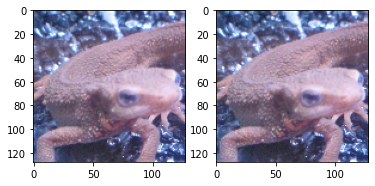

In [7]:
# DCT hyoer-parameter

# DCT
def dct(img, T=8, channel=3):
    H, W, _ = img.shape
    F = np.zeros((H, W, channel), dtype=np.float32)
    
    theta = np.pi / (2 * T)

    for c in range(channel):
        for vi in range(0, H, T):
            for ui in range(0, W, T):
                for v in range(T):
                    for u in range(T):
                        cu = 1 / np.sqrt(2) if u == 0 else 1
                        cv = 1 / np.sqrt(2) if v == 0 else 1
                        coef1, coef2 = np.meshgrid(np.cos((2 * np.arange(0, T) + 1) * u * theta), np.cos((2 * np.arange(0, T) + 1) * v * theta))
                        F[vi + v, ui + u, c] = 2 * cu * cv * np.sum(img[vi : vi + T, ui : ui + T, c] * coef1 * coef2) / T
                        
    return F


# IDCT
def idct(F,  T=8, K=8, channel=3):
    H, W, _ = F.shape
    out = np.zeros((H, W, channel), dtype=np.float32)

    theta = np.pi / (2 * T)
    
    c_mat = np.ones([T, T])
    c_mat[0] /= np.sqrt(2)
    c_mat[:, 0] /= np.sqrt(2)
    
    for c in range(channel):
        for yi in range(0, H, T):
            for xi in range(0, W, T):
                for y in range(T):
                    for x in range(T):
                        coef1, coef2 = np.meshgrid(np.cos((2 * x + 1) * np.arange(0, T) * theta), np.cos((2 * y + 1) * np.arange(0, T) * theta))
                        out[yi + y, xi + x, c] = 2 * np.sum(F[yi : yi + K, xi : xi + K, c] * coef1[:K, :K] * coef2[:K, :K] * c_mat[:K, :K]) / T

    out = np.clip(out, 0, 255)
    out = np.round(out).astype(np.uint8)

    return out

# DCT
F = dct(img_128)

# IDCT
out = idct(F)

plt.subplot(1, 2, 1)
plt.imshow(img_128)
plt.subplot(1, 2 ,2)
plt.imshow(out)
plt.show()

### Q.37. PSNR

IDCTで用いるDCT係数を8でなく、4にすると画像の劣化が生じる。 入力画像とIDCT画像のPSNRを求めよ。また、IDCTによるビットレートを求めよ。

PSNR(Peak Signal to Noise Ratio) は信号対雑音比と呼ばれ、画像がどれだけ劣化したかを示す。

PSNRが大きいほど、画像が劣化していないことを示し、次式で定義される。 v_maxは取りうる値の最大値で[0,255]の表示なら v_max=255　となる。

<img src="https://github.com/TakuroTerui/Gasyori100knock/raw/master/questions/question_31_40/images/psnr.png"/>

式中のMSEは Mean Squared Error(平均二乗誤差) と呼ばれ、二つの画像の差分の二乗の平均値を示す。

<img src="https://github.com/TakuroTerui/Gasyori100knock/raw/master/questions/question_31_40/images/mse.png"/>

ビットレートとは8x8でDCTを行い、IDCTでKxKの係数までを用いた時に次式で定義される。

<img src="https://github.com/TakuroTerui/Gasyori100knock/raw/master/questions/question_31_40/images/bitrate.png"/>

In [8]:
# MSE
def mse(img1, img2):
    h, w, c = img1.shape
    mse = np.sum((img1 - img2) ** 2) / (h * w * c)
    return mse

# PSNR
def psnr(img1, img2, vmax=255):
    _mse = 1e-10 if mse(img1, img2) == 0 else mse(img1, img2)
    return 10 * np.log10(vmax * vmax / _mse)

# bitrate
def bitrate(t, k):
    return 1. * t * (k ** 2) / (t ** 2)

# dct coef = 8
print("MSE =", mse(img_128, out))
print("PSNR =", psnr(img_128, out))
print("Bitrate =", bitrate(8, 8))

MSE = 0.0
PSNR = 148.13080360867912
Bitrate = 8.0


MSE = 51.35107421875
PSNR = 31.025308277857178
Bitrate = 2.0


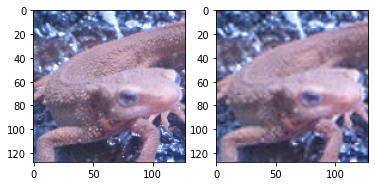

In [9]:
# DCT
F = dct(img_128, T=8)
out = idct(F, T=8, K=4)

print("MSE =", mse(img_128, out))
print("PSNR =", psnr(img_128, out))
print("Bitrate =", bitrate(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(img_128)
plt.subplot(1, 2 ,2)
plt.imshow(out)
plt.show()

### Q.38. JPEG圧縮 (Step.2)DCT+量子化

DCT係数を量子化し、IDCTで復元せよ。また、その時の画像の容量を比べよ。

DCT係数を量子化することはjpeg画像にする符号化で用いられる手法である。

量子化とは、値を予め決定された区分毎に値を大まかに丸め込む作業であり、floorやceil, roundなどが似た計算である。

JPEG画像ではDCT係数を下記で表される量子化テーブルに則って量子化する。 量子化では8x8の係数をQで割り、四捨五入する。その後Qを掛けることで行われる。 IDCTでは係数は全て用いるものとする。

（量子化テーブルが明確に分からなかったため、ここでは下記で行う。）

MSE = 57.62725830078125
PSNR = 30.524524029760567
Bitrate = 2.0


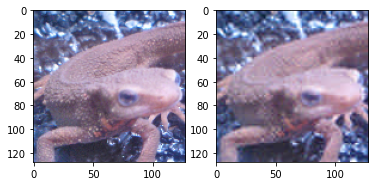

In [10]:
def quantization(F, T=8):
    h, w, channel = F.shape

    Q = np.array([[12, 18, 24, 30, 36, 42, 48, 54],
                       [18, 24, 30, 36, 42, 48, 54, 60],
                       [24, 30, 36, 42, 48, 54, 60, 66],
                       [30, 36, 42, 48, 54, 60, 66, 72],
                       [36, 42, 48, 54, 60, 66, 72, 78],
                       [42, 48, 54, 60, 66, 72, 78, 84],
                       [48, 54, 60, 66, 72, 78, 84, 90],
                       [54, 60, 66, 72, 78, 84, 90, 96]])

    for ys in range(0, h, T):
        for xs in range(0, w, T):
            for c in range(channel):
                F[ys: ys + T, xs: xs + T, c] =  np.round(F[ys: ys + T, xs: xs + T, c] / Q) * Q

    return F

F = dct(img_128)
F = quantization(F)
out = idct(F, K=4)

print("MSE =", mse(img_128, out))
print("PSNR =", psnr(img_128, out))
print("Bitrate =", bitrate(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(img_128)
plt.subplot(1, 2 ,2)
plt.imshow(out)
plt.show()

### Q.39. JPEG圧縮 (Step.3)YCbCr表色系

YCbCr表色形において、Yを0.7倍してコントラストを暗くせよ。

YCbCr表色系とは、画像を明るさを表すY、輝度と青レベルの差Cb、輝度と赤レベルの差Crに分解する表現方法である。

これはJPEG変換で用いられる。

RGBからYCbCrへの変換は次式。

- Y = 0.299 * R + 0.5870 * G + 0.114 * B
- Cb = -0.1687 * R - 0.3313 * G + 0.5 * B + 128
- Cr = 0.5 * R - 0.4187 * G - 0.0813 * B + 128

YCbCrからRGBへの変換は次式。

- R = Y + (Cr - 128) * 1.402
- G = Y - (Cb - 128) * 0.3441 - (Cr - 128) * 0.7139
- B = Y + (Cb - 128) * 1.7718

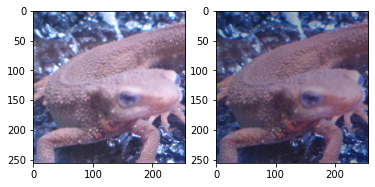

In [11]:
def rgb2ycbcr(img):
    h, w, _ = img.shape
    ycbcr = np.zeros([h, w, 3], dtype=np.float32)
    ycbcr[..., 0] = 0.2990 * img[..., 2] + 0.5870 * img[..., 1] + 0.1140 * img[..., 0]
    ycbcr[..., 1] = -0.1687 * img[..., 2] - 0.3313 * img[..., 1] + 0.5 * img[..., 0] + 128.
    ycbcr[..., 2] = 0.5 * img[..., 2] - 0.4187 * img[..., 1] - 0.0813 * img[..., 0] + 128.
    return ycbcr

# Y Cb Cr -> BGR
def ycbcr2rgb(ycbcr):
    h, w, _ = ycbcr.shape
    out = np.zeros([h, w, 3], dtype=np.float32)
    out[..., 2] = ycbcr[..., 0] + (ycbcr[..., 2] - 128.) * 1.4020
    out[..., 1] = ycbcr[..., 0] - (ycbcr[..., 1] - 128.) * 0.3441 - (ycbcr[..., 2] - 128.) * 0.7139
    out[..., 0] = ycbcr[..., 0] + (ycbcr[..., 1] - 128.) * 1.7718
    
    out = np.clip(out, 0, 255)
    out = out.astype(np.uint8)
    return out

ycbcr = rgb2ycbcr(img_orig)
ycbcr[..., 0] *= 0.7
out = ycbcr2rgb(ycbcr)

plt.subplot(1, 2, 1)
plt.imshow(img_orig)
plt.subplot(1, 2 ,2)
plt.imshow(out)
plt.show()

### Q.40. JPEG圧縮 (Step.4)YCbCr+DCT+量子化

YCbCr表色系に変換し、DCTを行った後に量子化し、IDCTで画像を復元せよ。

アルゴリズムは、

1. RGB を YCbCrに変換
2. YCbCrをDCT
3. DCTしたものを量子化
4. 量子化したものをIDCT
5. DCTしたYCbCrをRGBに変換

これで画像の容量が小さくなっている（画像を保存して比較するとわかる）

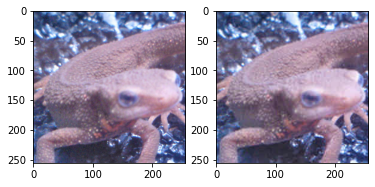

In [12]:
x = rgb2ycbcr(img_orig)
x = dct(x)
x = quantization(x)
x = idct(x, K=4)
out = ycbcr2rgb(x)

plt.subplot(1, 2, 1)
plt.imshow(img_orig)
plt.subplot(1, 2 ,2)
plt.imshow(out)
plt.show()